#	Определение температуры стали

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Нужно построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.

Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных
Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка библиотек

In [1]:
! pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

#ML
from scipy import stats as st
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Другое
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
from time import time
from tqdm import tqdm

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive')

# константы
RANDOM_STATE = 270223

Mounted at /content/drive


## Загрузка и изучение данных

In [3]:
# Загрузим данные:
try:
    df_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    df_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
except:
    df_arc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_arc_new.csv')
    df_bulk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_bulk_time_new.csv')
    df_gas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_gas_new.csv')
    df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_temp_new.csv')
    df_wire = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_wire_new.csv')
    df_wire_time = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/12_data_wire_time_new.csv')

In [4]:
# Напишем функцию для просмотра значений внутри столбцов:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].sort_values().unique())

### Данные об электродах

In [5]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [6]:
len(df_arc['key'].unique())

3214

In [7]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
show_rows(df_arc)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Начало нагрева дугой
['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-06 17:06:48' '2019-09-06 17:21:58' '2019-09-06 17:24:54']
Уникальные значения столбца Конец нагрева дугой
['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-06 17:09:52' '2019-09-06 17:22:55' '2019-09-06 17:26:15']
Уникальные значения столбца Активная мощность
[0.22312  0.223238 0.223895 ... 1.444904 1.458773 1.463773]
Уникальные значения столбца Реактивная мощность
[-7.15479924e+02  1.53777000e-01  1.53921000e-01 ...  1.22306300e+00
  1.25862800e+00  1.27028400e+00]


In [9]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


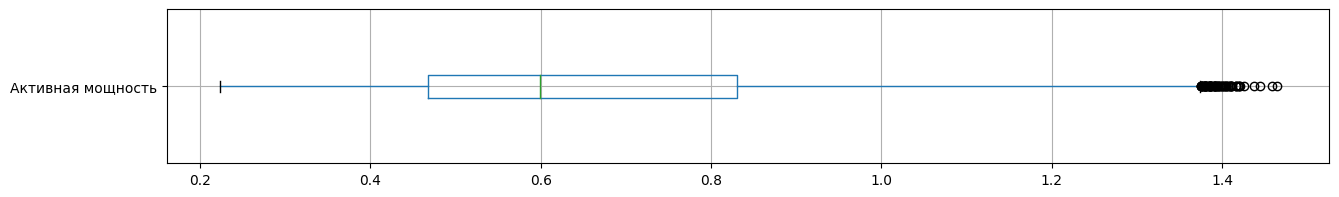

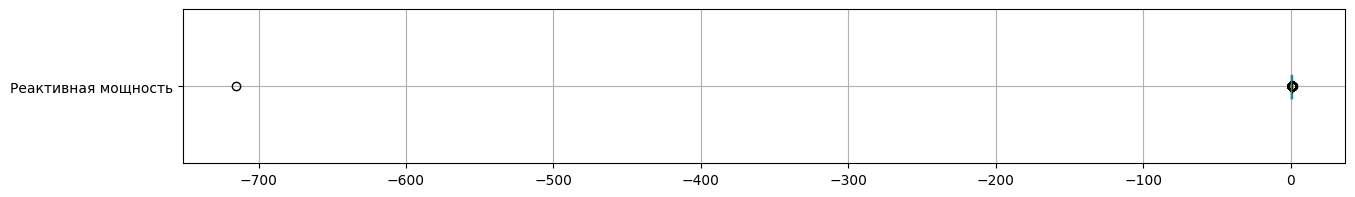

In [10]:
# Рассмотрим графики:
plt.figure(figsize=(15, 2))
df_arc.boxplot('Активная мощность', vert=False)
plt.show()

plt.figure(figsize=(15, 2))
df_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

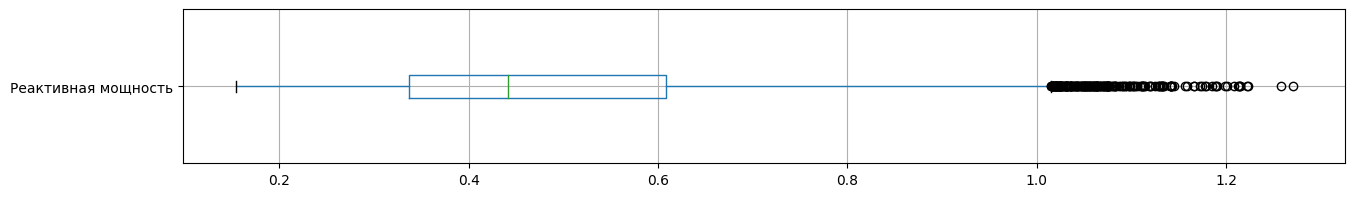

In [11]:
# В столбце 'Реактивная мощность' есть выброс.
# Удалим аномальное значение и снова посмотрим график:
df_arc = df_arc[df_arc['Реактивная мощность']>=0]

plt.figure(figsize=(15, 2))
df_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

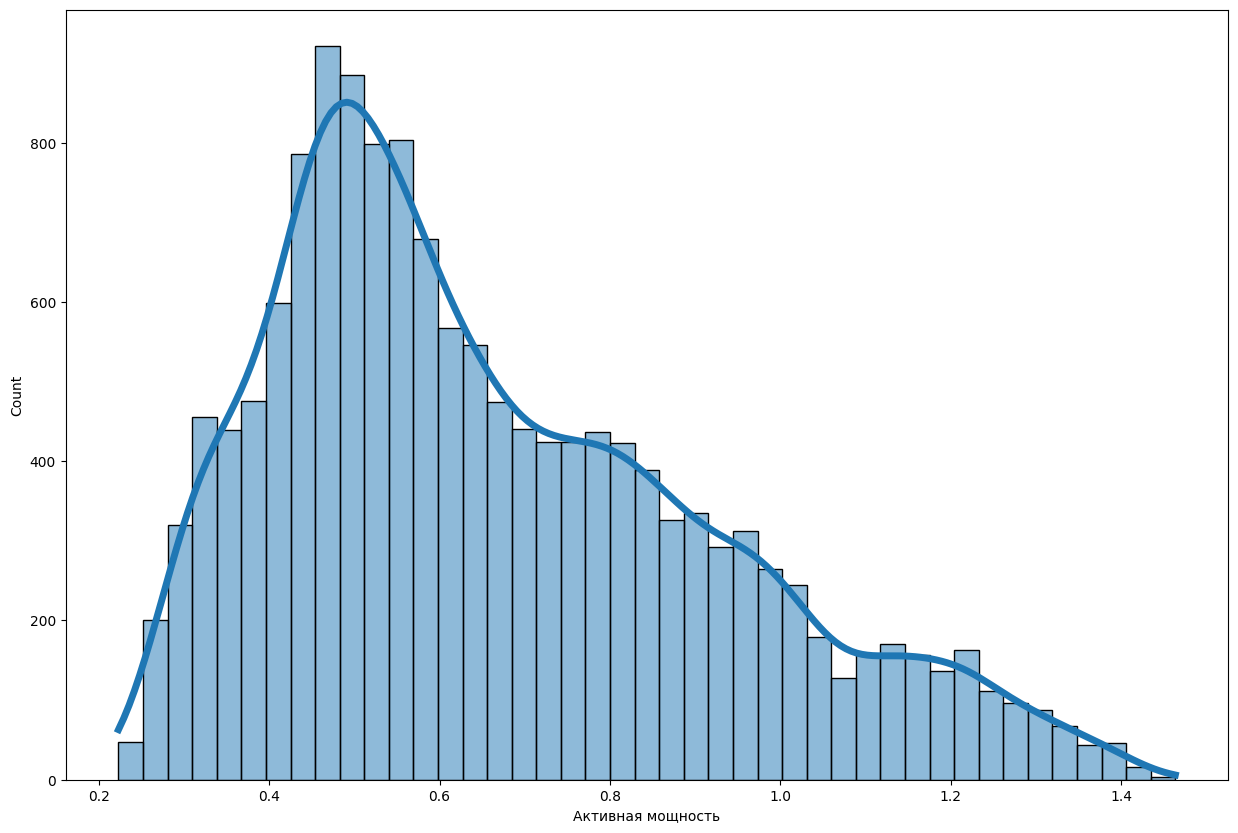

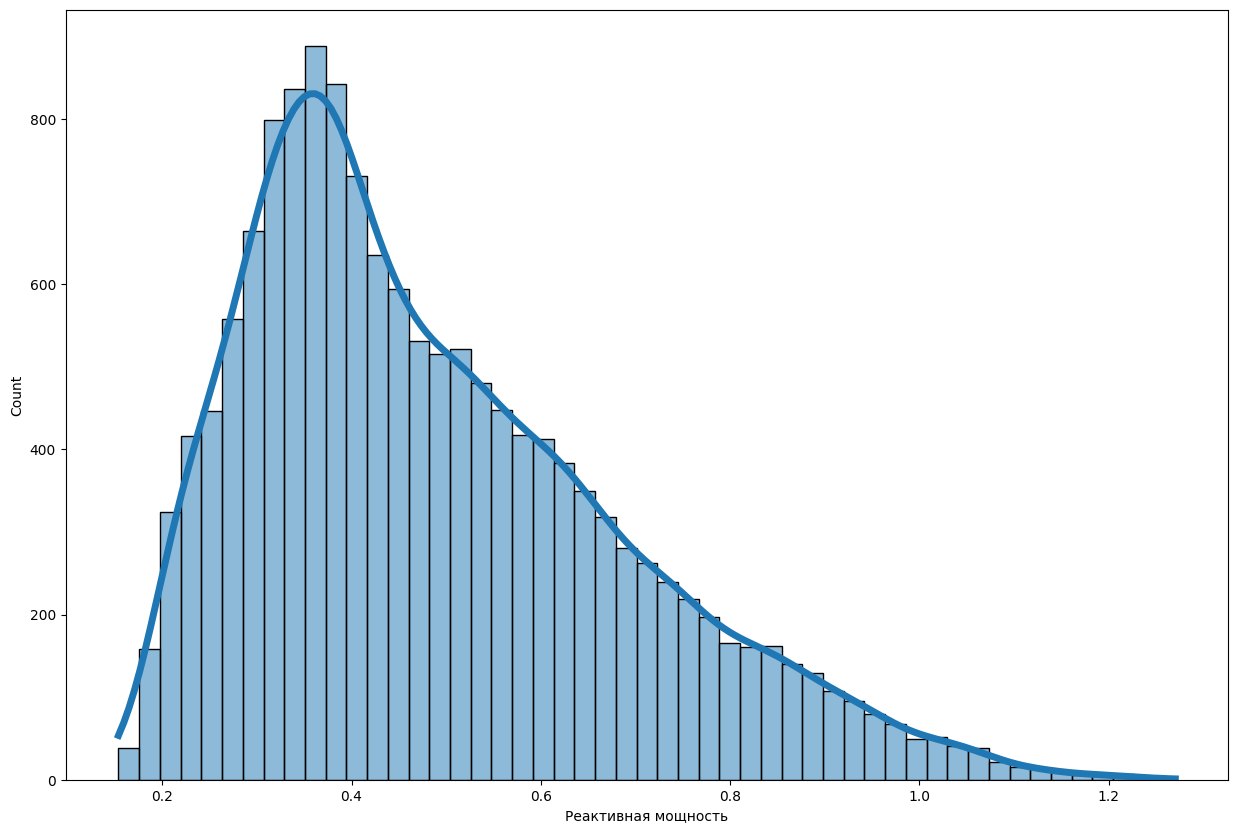

In [12]:
# Рассмотрим плотность распределения:
plt.figure(figsize=(15,10))
sns.histplot(df_arc['Активная мощность'], kde=True, line_kws={'linewidth':5})
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df_arc['Реактивная мощность'], kde=True, line_kws={'linewidth':5})
plt.show()

> Как видно из графиков, есть значения, которые уходят от нормального распределения. У заказчика необходимо выяснить, являются ли эти значения выбросами или обусловлены технологическим процессом и такая подача мощностей была необходима для очистки стали.

#### Вывод
**Как видно из данных в таблице data_arc.csv:**

1. содержатся данные об электродах, то есть нагреве сырья, времени начала нагрева дугой и конце, а также мощностях. Исходя из данных мощностей можно рассчитать полную мощность, а при умножении полной мощности на время нагрева можно получить энергию, которая станет дополнительным признаком в модели.
2. Пропусков в таблице нет.
3. В столбце 'Реактивная мощность' был выброс. Эта строка была удалена.
4. Как видно из графиков, есть значения, которые уходят от нормального распределения. У заказчика необходимо выяснить, являются ли эти значения выбросами или обусловлены технологическим процессом и такая подача мощностей была необходима для очистки стали.

### Данные о подаче сыпучих материалов (объём) и (время)

In [13]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
len(df_bulk['key'].unique())

3129

In [15]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [16]:
len(df_bulk_time['key'].unique())

3129

In [17]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [19]:
show_rows(df_bulk)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Уникальные значения столбца Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Уникальные значения столбца Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 1

Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

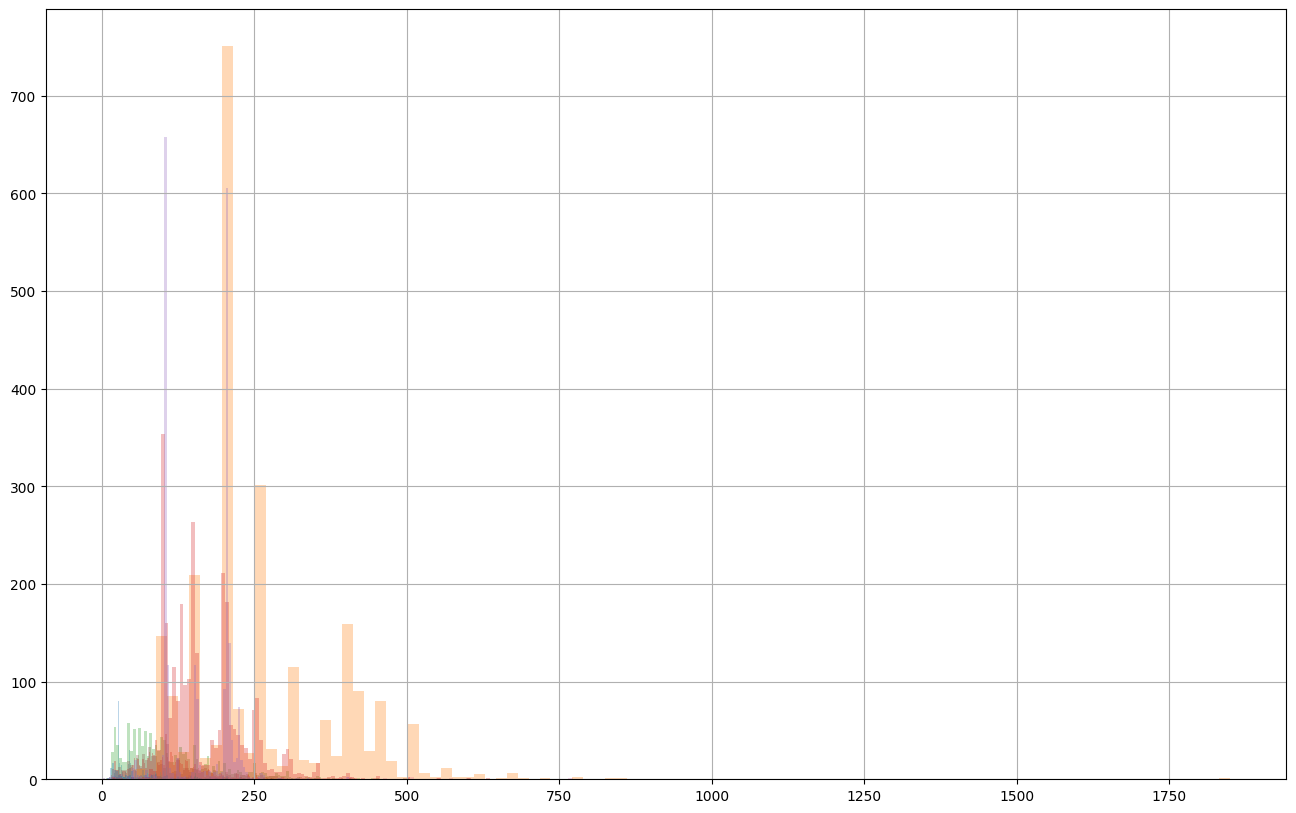

In [20]:
for column in df_bulk.columns:
    if column[0] == 'B':
        print(column)
        display(df_bulk[column].describe())
        df_bulk[column].hist(bins=100, figsize=(16,10), alpha=0.3)

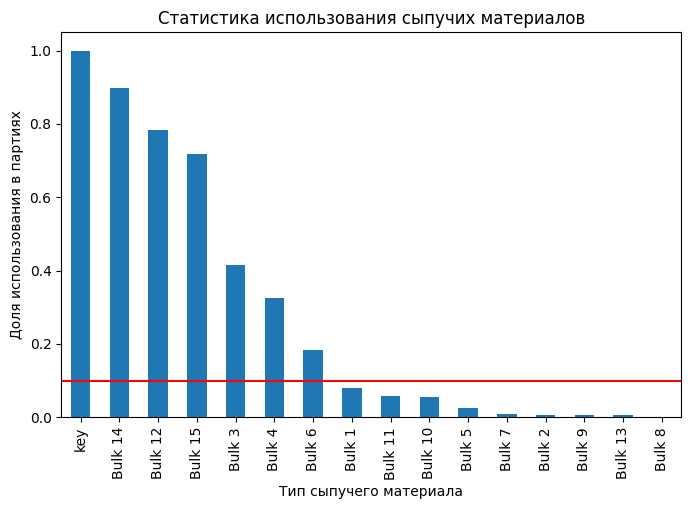

In [21]:
plt.figure(figsize = (8,5))
ax = (~df_bulk_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала');

> Как можно видеть из графика, сыпучие материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 - используются при изготовлении менее 10% партий.

In [22]:
display(df_bulk_time.drop('key', axis=1).describe().T\
            .style.background_gradient(cmap='GnBu'))

,count,unique,top,freq
Bulk 1,252,252,2019-05-03 17:42:46,1
Bulk 2,22,22,2019-05-07 15:39:35,1
Bulk 3,1298,1298,2019-05-03 20:40:25,1
Bulk 4,1014,1014,2019-05-03 11:28:48,1
Bulk 5,77,77,2019-05-07 15:19:17,1
Bulk 6,576,576,2019-05-03 19:09:15,1
Bulk 7,25,25,2019-05-07 18:11:01,1
Bulk 8,1,1,2019-07-08 17:14:53,1
Bulk 9,19,19,2019-05-14 11:57:58,1
Bulk 10,176,176,2019-05-06 07:54:02,1


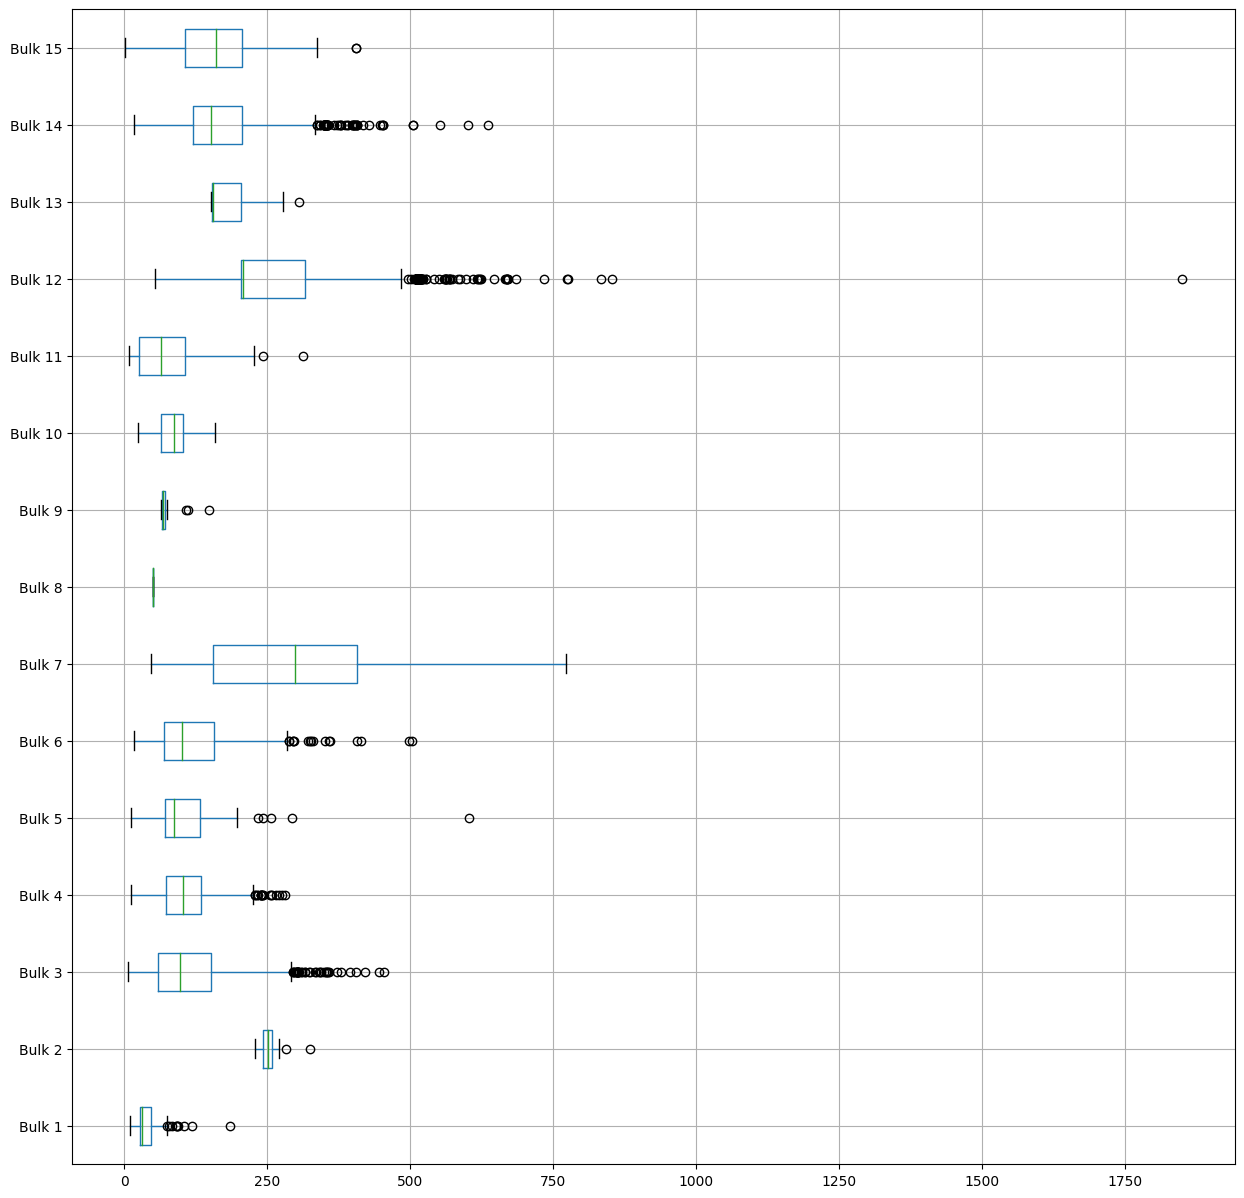

In [23]:
# Рассмотрим таблицу подачи материалов при плавке:
plt.figure(figsize=(15, 15))
df_bulk.boxplot([col for col in df_bulk.columns if col != 'key'], vert=False)
plt.show()

#### Вывод
**Как видно из данных в таблицах data_bulk.csv и data_bulk_time.csv:**

1. они связаны и содержат данные о подаче примесей для корректировки химического состава - времени подачи, а так же их объём. Из-за особенностей технологического процесса в таких 2.2.2. в таблицах много пропусков, так как, скорее всего, какая-либо примесь могла просто не добавляться. Такие пропуски можно заполнить нулями.
3. Почти все столбцы с небольшимы выбросами (данные за усами).
4. Как можно видеть из графика, сыпучие материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 - используются при изготовлении менее 10% партий.
5. Bulk 12 есть аномально большое значение. Думаю такую строку можно исключить, чтобы не исказить модель.

### Данные о продувке сплава газом

In [24]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [25]:
len(df_gas['key'].unique())

3239

In [26]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
show_rows(df_gas)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Газ 1
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


In [28]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


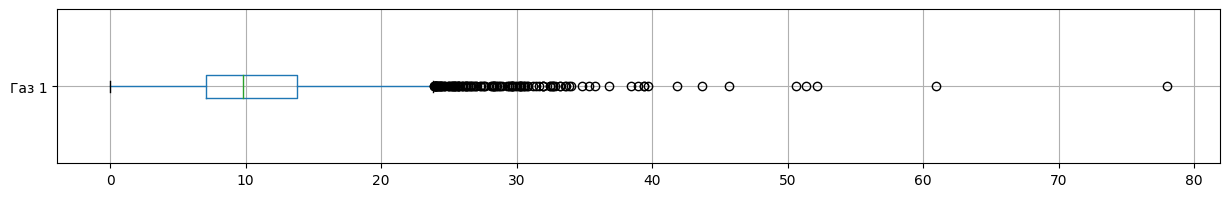

In [29]:
plt.figure(figsize=(15, 2))
df_gas.boxplot('Газ 1', vert=False)
plt.show()

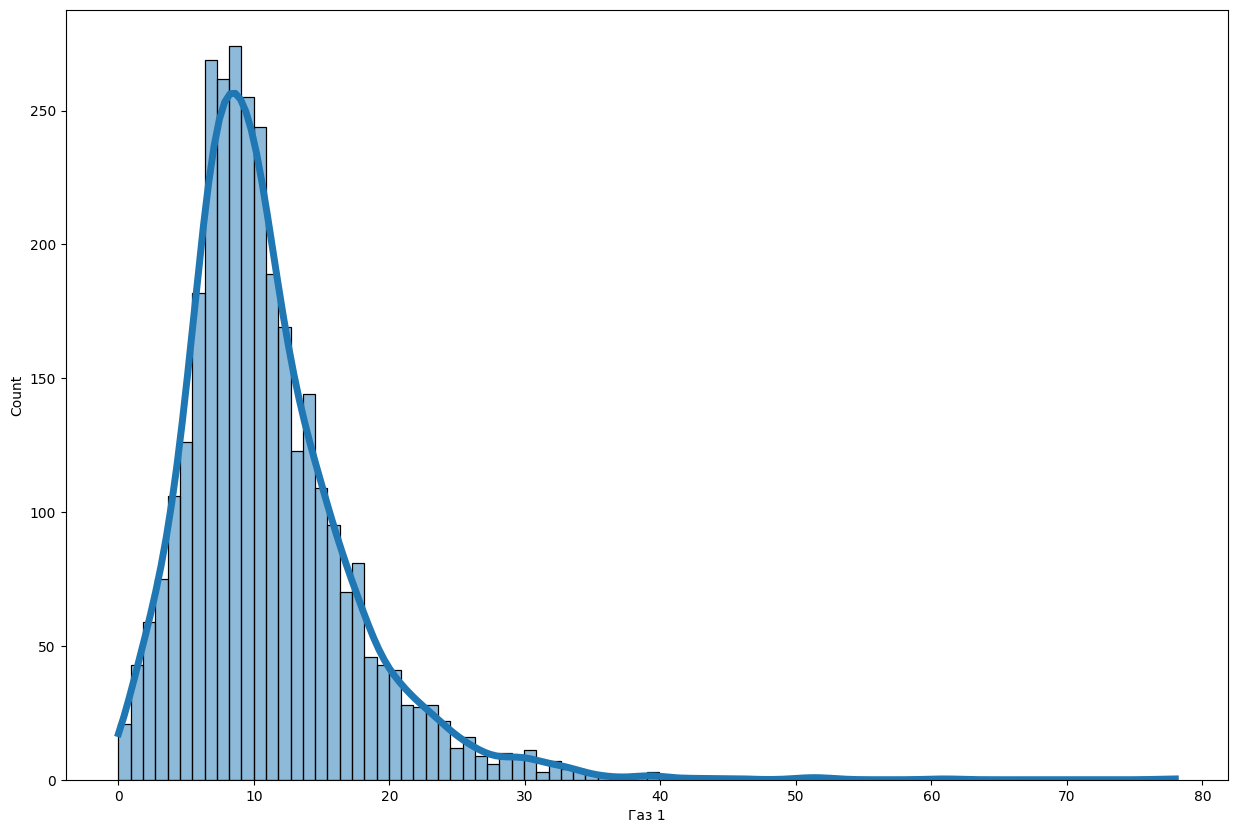

In [30]:
# Рассмотрим плотность распределения:
plt.figure(figsize=(15,10))
sns.histplot(df_gas['Газ 1'], kde=True, line_kws={'linewidth':5})
plt.show()

> Исходя из графиков: в подаче газа есть выбросы, предположительно значения выше 40. Возможно, значения меньше 40 связаны с технологическим процессом, и нужно данный вопрос уточнить у заказчика.

#### Вывод
**Как видно из данных в таблице data_gas.csv:**

1. содержатся данные о продувке сплава газом.
2. Пропусков в таблице нет.
3. Временных промежутков нет, то есть данные только об общем подаче газа на один ковш.
4. Как видно из графиков, есть значения, которые уходят от нормального распределения - это значения выше 40. У заказчика необходимо выяснить, являются ли эти значения выбросами или обусловлены технологическим процессом.

### Результаты измерения температуры

In [31]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [32]:
len(df_temp['key'].unique())

3216

In [33]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [34]:
show_rows(df_temp)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Время замера
['2019-05-03 11:02:04' '2019-05-03 11:07:18' '2019-05-03 11:11:34' ...
 '2019-09-06 17:21:48' '2019-09-06 17:24:44' '2019-09-06 17:30:05']
Уникальные значения столбца Температура
[1191. 1204. 1208. 1218. 1227. 1515. 1519. 1520. 1521. 1522. 1525. 1526.
 1527. 1528. 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538.
 1539. 1540. 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550.
 1551. 1552. 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562.
 1563. 1564. 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574.
 1575. 1576. 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586.
 1587. 1588. 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598.
 1599. 1600. 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610.
 1611. 1612. 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622.
 1623. 1624. 1625. 1626. 1627. 1628. 1629. 1630. 1631. 

In [35]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


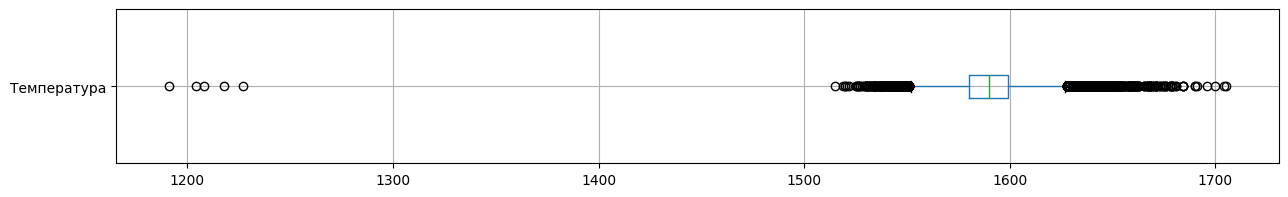

In [36]:
plt.figure(figsize=(15, 2))
df_temp.boxplot('Температура', vert=False)
plt.show()

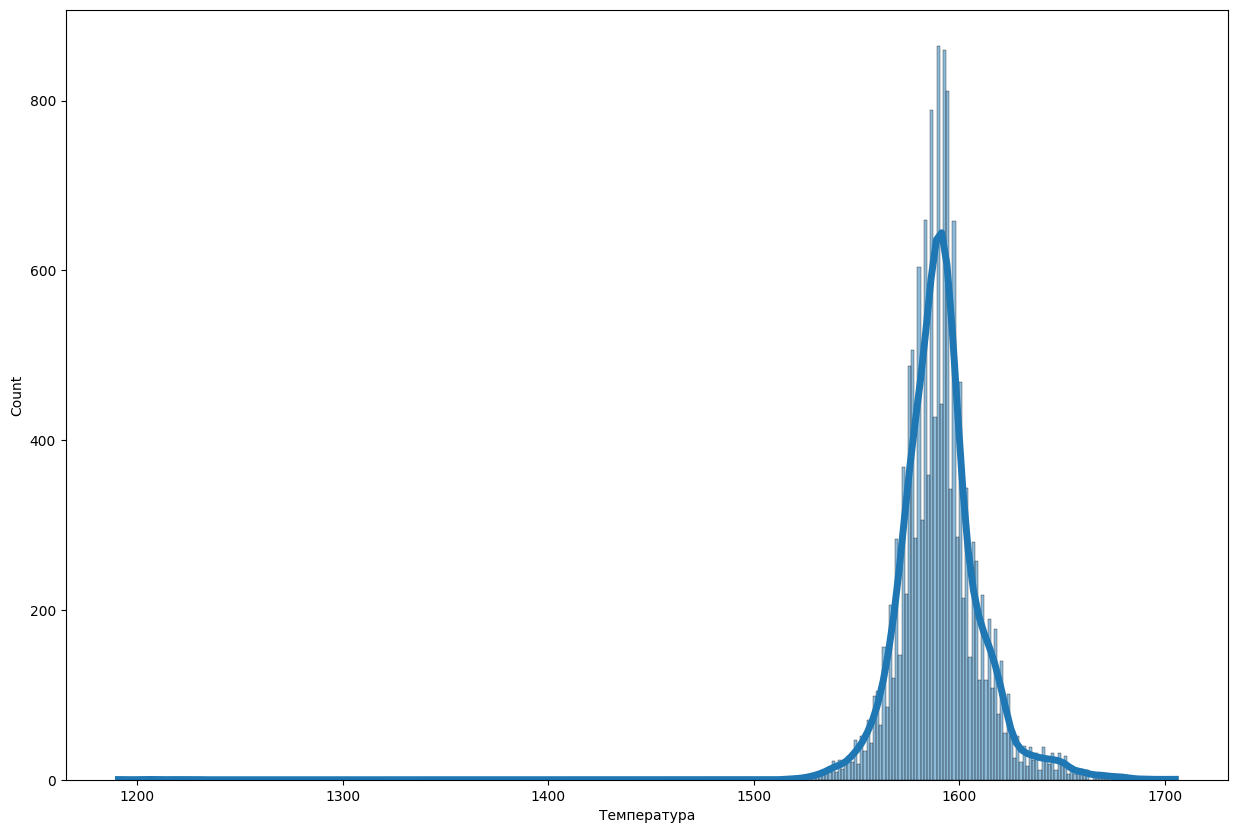

In [37]:
# Рассмотрим плотность распределения:
plt.figure(figsize=(15,10))
sns.histplot(df_temp['Температура'], kde=True, line_kws={'linewidth':5})
plt.show()

> Температура плавления стали от 1350 до 1535, соотвественно, есть значения, которые значительно ниже. Значения выше 1350 можно оставить.

#### Вывод
**Как видно из данных в таблице data_temp.csv:**

1. содержатся результаты измерения температуры.
2. **В данной таблице содержится целевая метрика, необходимая для исследования - конечная температура.**
3. В таблице много пропусков целевой метрики, скорее всего такие строки придется отбросить, чтобы не искажать исследование.
4. Температура плавления стали от 1350 до 1535, соотвественно, есть значения, которые значительно ниже, их также придётся удалить.

### Данные о проволочных материалах (объём) и (время)

In [38]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
len(df_wire['key'].unique())

3081

In [40]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
len(df_wire_time['key'].unique())

3081

In [42]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [43]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

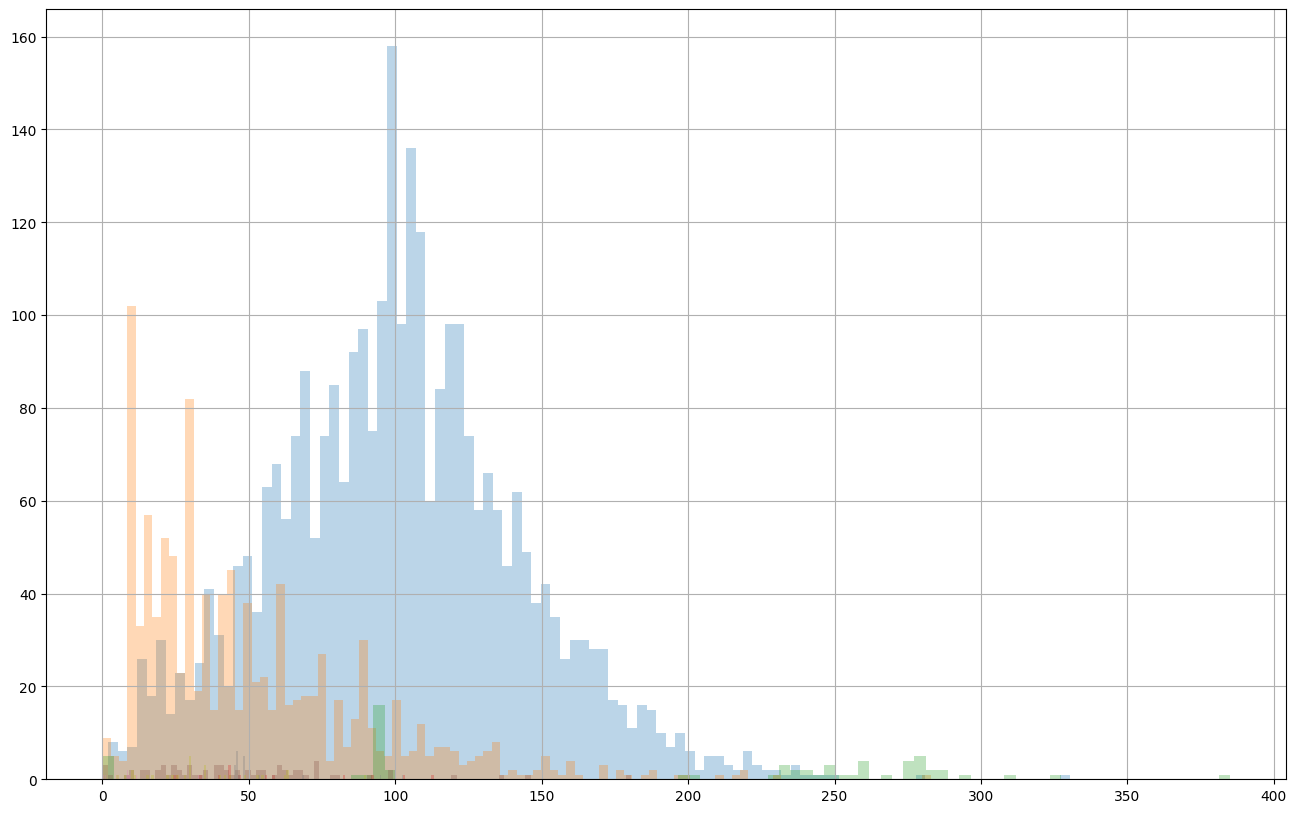

In [44]:
for column in df_wire.columns:
    if column[0] == 'W':
        print(column)
        display(df_wire[column].describe())
        df_wire[column].hist(bins=100, figsize=(16,10), alpha=0.3)

Text(0.5, 0, 'Тип проволочного материала')

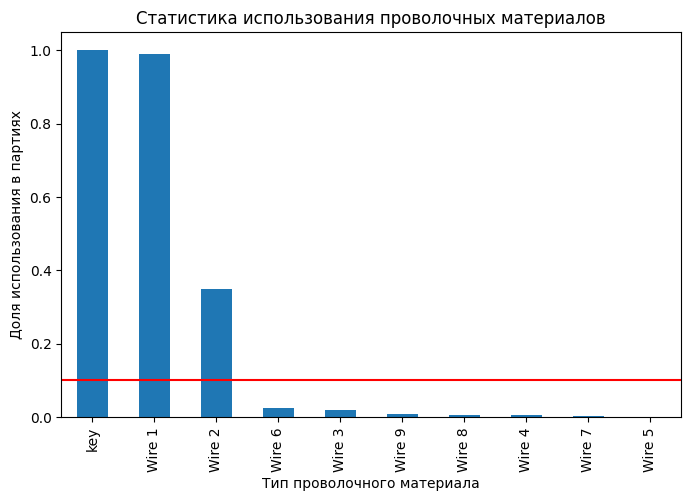

In [45]:
plt.figure(figsize = (8,5))
ax = (~df_wire_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')

> Есть проволочные материалы, которые используются очень редко. И таких много.

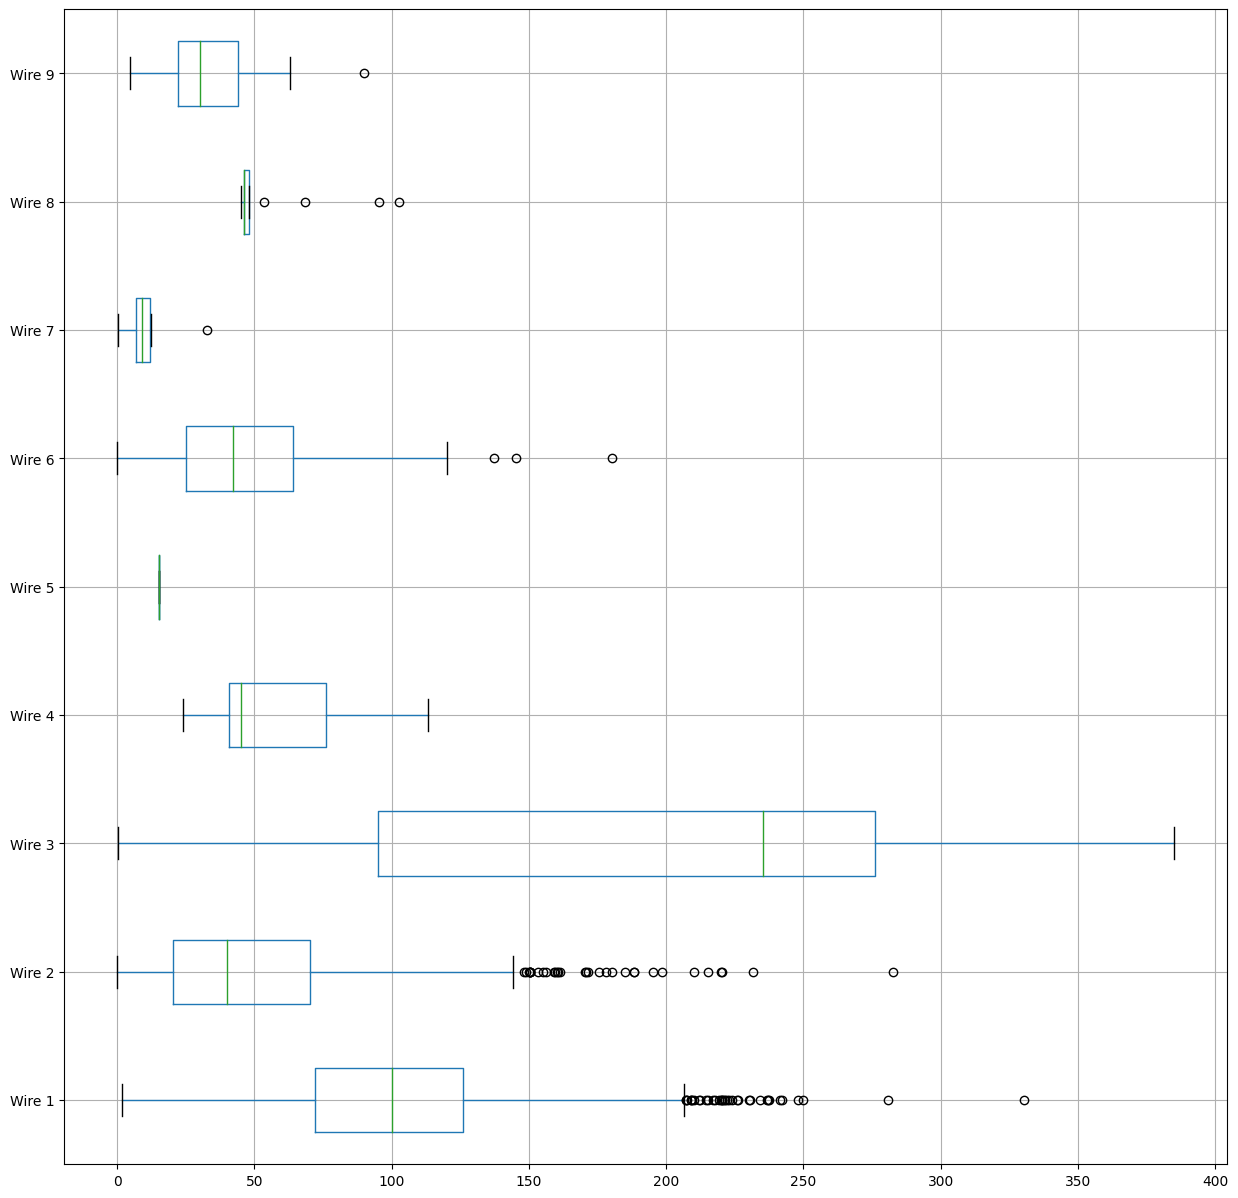

In [46]:
plt.figure(figsize=(15, 15))
df_wire.boxplot([col for col in df_wire.columns if col != 'key'], vert=False)
plt.show()

In [47]:
display(df_wire_time.drop('key', axis=1).describe().T\
            .style.background_gradient(cmap='GnBu'))

,count,unique,top,freq
Wire 1,3055,3055,2019-05-03 11:06:19,1
Wire 2,1079,1079,2019-05-03 13:15:34,1
Wire 3,63,63,2019-05-04 04:34:27,1
Wire 4,14,14,2019-05-07 15:19:17,1
Wire 5,1,1,2019-08-13 06:14:30,1
Wire 6,73,73,2019-05-07 14:46:05,1
Wire 7,11,11,2019-07-27 05:49:05,1
Wire 8,19,19,2019-05-14 11:29:24,1
Wire 9,29,29,2019-05-04 17:21:27,1


#### Вывод
**Как видно из данных в таблицах data_wire.csv и data_wire_time.csv:**

1. они связаны и содержат данные о подаче примесей для корректировки химического состава - времени подачи, а так же их объём.
2. Из-за особенностей технологического процесса в таких таблицах много пропусков, так как, скорее всего, какая-либо примесь могла просто не добавляться. Такие пропуски можно заполнить нулями.
3. Почти все столбцы с небольшимы выбросами (данные за усами).
4. Wire 5 добавляли лишь единожды. Возможно такими данными можно пренебречь.
5. В Wire 1 и Wire 2 есть аномальные значения. Думаю такие строки можно исключить, чтобы не исказить модель.

## Выводы
<ol>
    <li>В таблицах разное количество уникальных номеров партии key. Это может означать, что данные по партии могут быть утеряны или над ней не выполнялся технологический этап.</li>
    <li>Таблицы data_arc и data_temp обладают записями с одинаковыми значениями key в разное время применения технологической операции. Количество записей у одной партии для каждой таблицы может различаться.</li>
    <li>В таблице data_temp есть пропуски значений в целевой метрике - температуры сплава. Возможно это ошибка датчика, который не передал информацию или отсутствие действия/замера на этой стадии. Кроме того, в данных есть показатели ниже температуры плавления стали. Вообще, прежде, чем объединять таблицы, нужно проверить данные на "реальность": сделать таблицу с итоговым значением температуры (целевое значение) и сравнить время конечного измерения температуры с остальными таблицами в которых так же указано время (время подачи материала для плавления по двум таблицам и время нагрева). Для обучения модели нам нужно точно знать, что конечное измерение температуры было произведено ПОСЛЕ всех этапов нагрева и подачи всех материлов.</li>
    <li> В таблицах data_bulk и data_wire указаны 15 и 9 признаков с данными о различных добавках. Это значит, что в каждую партию может идти определенный набор из них и только единицам требуется использование всех возможных добавок. В этих таблицах пропуски можно заполнить значением 0.</li>
    <li>Несоответсвующий тип данных:
        <ul>
            <li>Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа.</li>
            <li>Данные о времени хранятся в формате строки. Необходимо перевести время в формат datetime.</li>
        </ul></li>
    <li>Разноязычные названия столбцов. Имена столбцов нужно превести к английском языку строчными буквами и избавиться от пробелов.</li>
    </ol>

## Предобработка данных
Для проведения исследования нам нужно точно знать, что конечное измерение температуры было произведено ПОСЛЕ всех этапов нагрева и подачи всех материлов.

Таблицу df_temp с целевой метрикой преобразуем и найдем целевую - последнее измерение температуры, а так же сохраним данные о первом измерении, как дополнительном параметре:

In [48]:
# преобразовываем в нужный формат
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

# создаём сводную таблицу с первым измерением, для дальнейшего исследования
df_temp_last = df_temp.groupby('key').agg('max')['Время замера']
df_temp_last = pd.DataFrame(df_temp_last)
df_temp_last = df_temp_last.merge(df_temp, on='Время замера', how='left')
df_temp_last.set_axis(['time_last','key','temp_last'], axis = 'columns', inplace = True)

# создаём сводную таблицу с последним измерением, целевой метрикой
df_temp_first = df_temp.groupby('key').agg('min')['Время замера']
df_temp_first = pd.DataFrame(df_temp_first)
df_temp_first = df_temp_first.merge(df_temp, on='Время замера', how='left')
df_temp_first.set_axis(['time_first','key','temp_first'], axis = 'columns', inplace = True)

# объединяем таблицы
df = df_temp_first.merge(df_temp_last, on='key', how='left')\
                  .reindex(columns=['key', 'time_first', 'temp_first', 'time_last', 'temp_last'])

# сохраним список с пустыми значениями целевой метрики
keys_with_na = list(df[df['temp_last'].isna()]['key'])
keys_not_na = list(df[~df['temp_last'].isna()]['key'])

# посмотрим таблицу
df

,key,time_first,temp_first,time_last,temp_last
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [49]:
df['temp_last'].isna().sum()

739

Как видно из таблицы, у целевой метрики есть пропуски. Очевидно, что такие пропущенные значения заполнить невозможно и эти строки придётся удалить.

In [50]:
df = df.dropna()
df['temp_last'].isna().sum()

0

Так же удалим те строки, где первое измерение равно последнему, чтобы не допустить утечки данных.

In [51]:
df = df[df['temp_first'] != df['temp_last']]

In [52]:
# Создадим функции для проверки "реальности" и вывода строк, которые не прошли проверку:
def check_time(row):
    return row['time_last'] == row['max_time']

def list_of_errors(list_of_data):
    '''

    Функция для объединения таблиц и проверки адекватности с выводом строк, не соответсвующих значению,
    т.к. используются только три оставшиеся таблицы со временем, объединим их всех с таблицей,
    где есть целевая метрика и получим список ключей, которые не прошли проверку на реальность

    '''
    data = df[['key', 'time_last']].merge(list_of_data[0], on='key', how='left')
    for dataset in list_of_data[1:]:
        data = data.merge(dataset, on='key', how='left')
    data['max_time'] = data.drop('key', axis=1).max(axis=1)
    data['check_error'] = data.apply(check_time, axis=1)
    keys = list(data[data['check_error'] == 0]['key'])
    return keys

In [53]:
# преобразуем данные в datetime
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

for col in df_bulk_time:
    if col != 'key':
        df_bulk_time[col] = pd.to_datetime(df_bulk_time[col], format='%Y-%m-%d %H:%M:%S')

for col in df_wire_time:
    if col != 'key':
        df_wire_time[col] = pd.to_datetime(df_wire_time[col], format='%Y-%m-%d %H:%M:%S')

# создадим сводную таблицу, где есть последнее время нагрева
df_arc_maxtime = pd.DataFrame(df_arc.groupby('key').agg('max')['Конец нагрева дугой'])
df_arc_maxtime.reset_index(inplace=True)

In [54]:
df_with_time = [df_arc_maxtime, df_bulk_time, df_wire_time]
keys_errors = list_of_errors(df_with_time)

len(keys_errors)

0

### Добавление дополнительных параметров и объединение таблиц
Полная мощность рассчитывается по формуле:

$$S=\sqrt{Q^2+P^2} $$

где:

S - полная мощность<br>
Q - активная мощность<br>
p - реактивная мощность<br>

In [55]:
# Дополним данные полной мощностью, полным временем нагрева
# и посчитаем энергию(время нагрева умноженное на полную мощность):
df_arc['Полная мощность'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** (0.5)
df_arc['Время нагрева'] = (
    df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
)

df_arc['Время нагрева'] = df_arc['Время нагрева'].apply(pd.Timedelta.total_seconds).astype('int')

df_arc['Энергия'] = df_arc['Время нагрева'] * df_arc['Полная мощность']

df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085,157,83.537345
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429,180,142.637202
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389,184,237.983620
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792,57,36.582120


Создадим сводную таблицу, в которой будет общая сумма времени нагрева и энергии по всей партии, которая войдет в итоговую таблицу:

In [56]:
df_arc_keys = df_arc.groupby('key').sum()[['Время нагрева', 'Полная мощность', 'Энергия']].reset_index()
df_arc_keys

,key,Время нагрева,Полная мощность,Энергия
0,1,1098,3.718736,770.282114
1,2,811,2.588349,481.760005
2,3,655,5.019223,722.837668
3,4,741,3.400038,683.455597
4,5,869,2.816980,512.169934
...,...,...,...,...
3209,3237,909,3.250657,630.503534
3210,3238,546,1.723937,286.052252
3211,3239,1216,6.014480,941.538764
3212,3240,839,4.082920,657.439848


По таблицам материалов, которые добавлялись в партию, заполним пустые значения нулями, и рассчитаем сумму по редким материалам, а те, которые добавляют часто - оставим без изменений, а так же добавим параметр, в котором указано количество добавок в данной партии.

In [57]:
def make_new_df(data, name):

    col_for_sum = []

    for col in data:
        if data[col].isna().sum() >= (len(data) - 1000):
            col_for_sum.append(col)

    data[f'count_{name}'] = data.drop('key', axis=1).count(axis=1)
    data[f'sum_{name}'] = data[col_for_sum].sum(axis=1)
    col_lasted = [col for col in data.columns if col not in col_for_sum]
    data = data[col_lasted].fillna(0)
    return data

In [58]:
bulk = make_new_df(df_bulk, 'bulk')
wire = make_new_df(df_wire, 'wire')

In [59]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   Bulk 3      3129 non-null   float64
 2   Bulk 4      3129 non-null   float64
 3   Bulk 12     3129 non-null   float64
 4   Bulk 14     3129 non-null   float64
 5   Bulk 15     3129 non-null   float64
 6   count_bulk  3129 non-null   int64  
 7   sum_bulk    3129 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 195.7 KB


In [60]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   Wire 1      3081 non-null   float64
 2   Wire 2      3081 non-null   float64
 3   count_wire  3081 non-null   int64  
 4   sum_wire    3081 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 120.5 KB


Создадим итоговую таблицу и сразу удалим те строки, где есть пропуски, поскольку у тех партий нет наблюдений в других таблицах:

In [61]:
df = df.drop(['time_first', 'time_last'], axis=1)
df = df.merge(bulk, on='key', how='left')
df = df.merge(wire, on='key', how='left')
df = df.merge(df_arc_keys[['key', 'Время нагрева', 'Полная мощность', 'Энергия']], on='key', how='left')
df = df.merge(df_gas, on='key', how='left')
df = df.dropna()

df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2432
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2293 non-null   int64  
 1   temp_first       2293 non-null   float64
 2   temp_last        2293 non-null   float64
 3   Bulk 3           2293 non-null   float64
 4   Bulk 4           2293 non-null   float64
 5   Bulk 12          2293 non-null   float64
 6   Bulk 14          2293 non-null   float64
 7   Bulk 15          2293 non-null   float64
 8   count_bulk       2293 non-null   float64
 9   sum_bulk         2293 non-null   float64
 10  Wire 1           2293 non-null   float64
 11  Wire 2           2293 non-null   float64
 12  count_wire       2293 non-null   float64
 13  sum_wire         2293 non-null   float64
 14  Время нагрева    2293 non-null   int64  
 15  Полная мощность  2293 non-null   float64
 16  Энергия          2293 non-null   float64
 17  Газ 1         

,key,temp_first,temp_last,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,count_bulk,sum_bulk,Wire 1,Wire 2,count_wire,sum_wire,Время нагрева,Полная мощность,Энергия,Газ 1
0,1,1571.0,1613.0,0.0,43.0,206.0,150.0,154.0,4.0,0.0,60.059998,0.00000,1.0,0.0,1098,3.718736,770.282114,29.749986
1,2,1581.0,1602.0,0.0,73.0,206.0,149.0,154.0,4.0,0.0,96.052315,0.00000,1.0,0.0,811,2.588349,481.760005,12.555561
2,3,1596.0,1599.0,0.0,34.0,205.0,152.0,153.0,4.0,0.0,91.160157,0.00000,1.0,0.0,655,5.019223,722.837668,28.554793
3,4,1601.0,1625.0,0.0,81.0,207.0,153.0,154.0,4.0,0.0,89.063515,0.00000,1.0,0.0,741,3.400038,683.455597,18.841219
4,5,1576.0,1602.0,0.0,78.0,203.0,151.0,152.0,4.0,0.0,89.238236,9.11456,2.0,0.0,869,2.816980,512.169934,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,2495,1570.0,1591.0,21.0,0.0,256.0,129.0,223.0,5.0,90.0,89.150879,0.00000,1.0,0.0,723,3.868721,694.177326,7.125735
2429,2496,1554.0,1591.0,0.0,63.0,256.0,129.0,226.0,5.0,122.0,114.179527,0.00000,1.0,0.0,940,5.070316,815.818538,9.412616
2430,2497,1571.0,1589.0,0.0,85.0,230.0,124.0,226.0,4.0,0.0,94.086723,9.04800,2.0,0.0,569,4.360918,823.020520,6.271699
2431,2498,1591.0,1594.0,90.0,0.0,206.0,129.0,207.0,5.0,101.0,118.110717,0.00000,1.0,0.0,750,3.909917,581.810739,14.953657


In [62]:
df.columns = ['key', 'temp_first', 'temp_last', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'count_bulk', 'sum_bulk', 'wire_1', 'wire_2', 'count_wire', 'sum_wire', 'heating_time', 'full_power', 'energy', 'gas']
# Приведем типы столбцов temp_first, temp_last, bulk, wire составляющих к целому типу,
# так как там храняться только целые числа:
df['temp_first'] = pd.to_numeric(df['temp_first'], downcast='integer')
df['temp_last'] = pd.to_numeric(df['temp_last'], downcast='integer')
df['bulk_3'] = pd.to_numeric(df['bulk_3'], downcast='integer')
df['bulk_12'] = pd.to_numeric(df['bulk_12'], downcast='integer')
df['bulk_14'] = pd.to_numeric(df['bulk_14'], downcast='integer')
df['bulk_15'] = pd.to_numeric(df['bulk_15'], downcast='integer')
df['count_bulk'] = pd.to_numeric(df['count_bulk'], downcast='integer')
df['sum_bulk'] = pd.to_numeric(df['sum_bulk'], downcast='integer')

df['count_wire'] = pd.to_numeric(df['count_wire'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2432
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2293 non-null   int64  
 1   temp_first    2293 non-null   int16  
 2   temp_last     2293 non-null   int16  
 3   bulk_3        2293 non-null   int16  
 4   bulk_4        2293 non-null   float64
 5   bulk_12       2293 non-null   int16  
 6   bulk_14       2293 non-null   int16  
 7   bulk_15       2293 non-null   int16  
 8   count_bulk    2293 non-null   int8   
 9   sum_bulk      2293 non-null   int16  
 10  wire_1        2293 non-null   float64
 11  wire_2        2293 non-null   float64
 12  count_wire    2293 non-null   int8   
 13  sum_wire      2293 non-null   float64
 14  heating_time  2293 non-null   int64  
 15  full_power    2293 non-null   float64
 16  energy        2293 non-null   float64
 17  gas           2293 non-null   float64
dtypes: float64(7), int16(7), int

### Оценка мультиколлинеарности

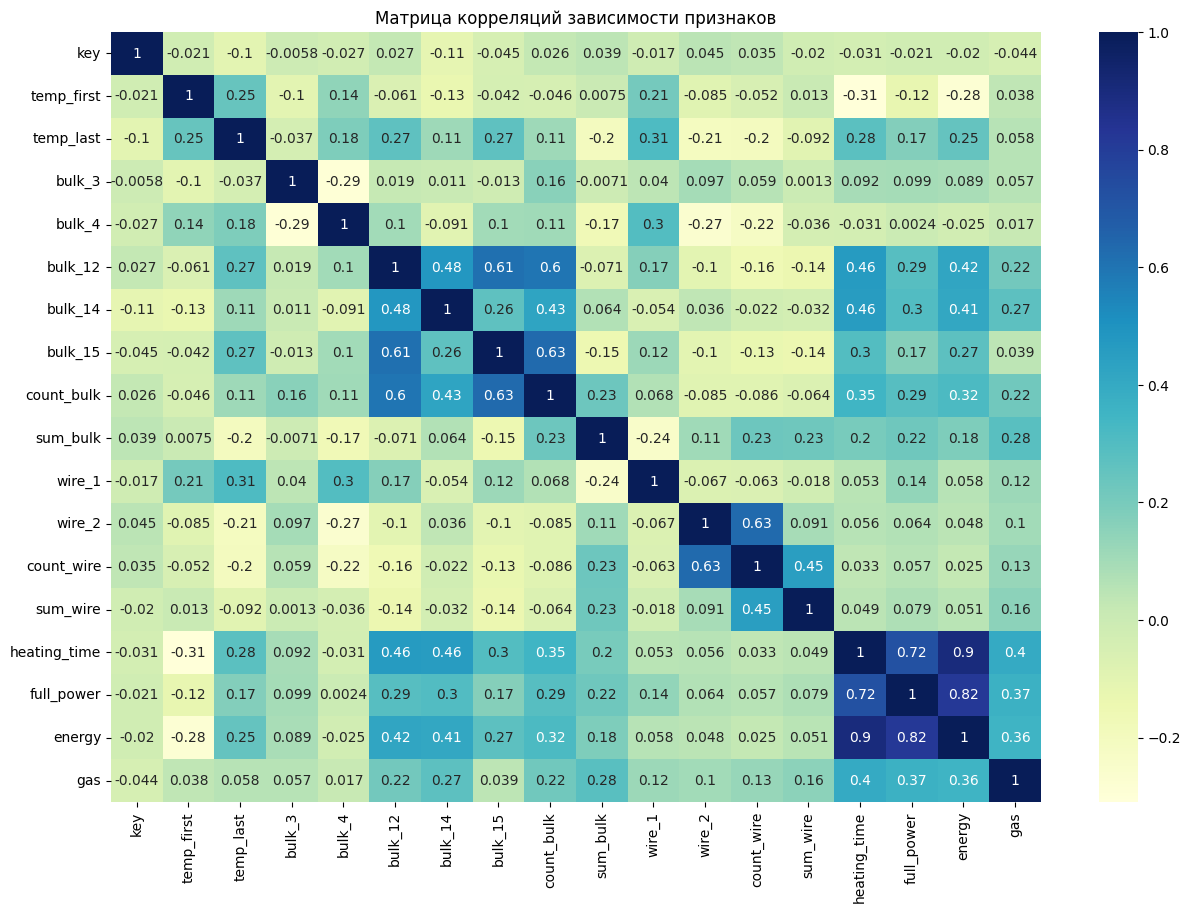

In [63]:
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций зависимости признаков')

sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

plt.show()

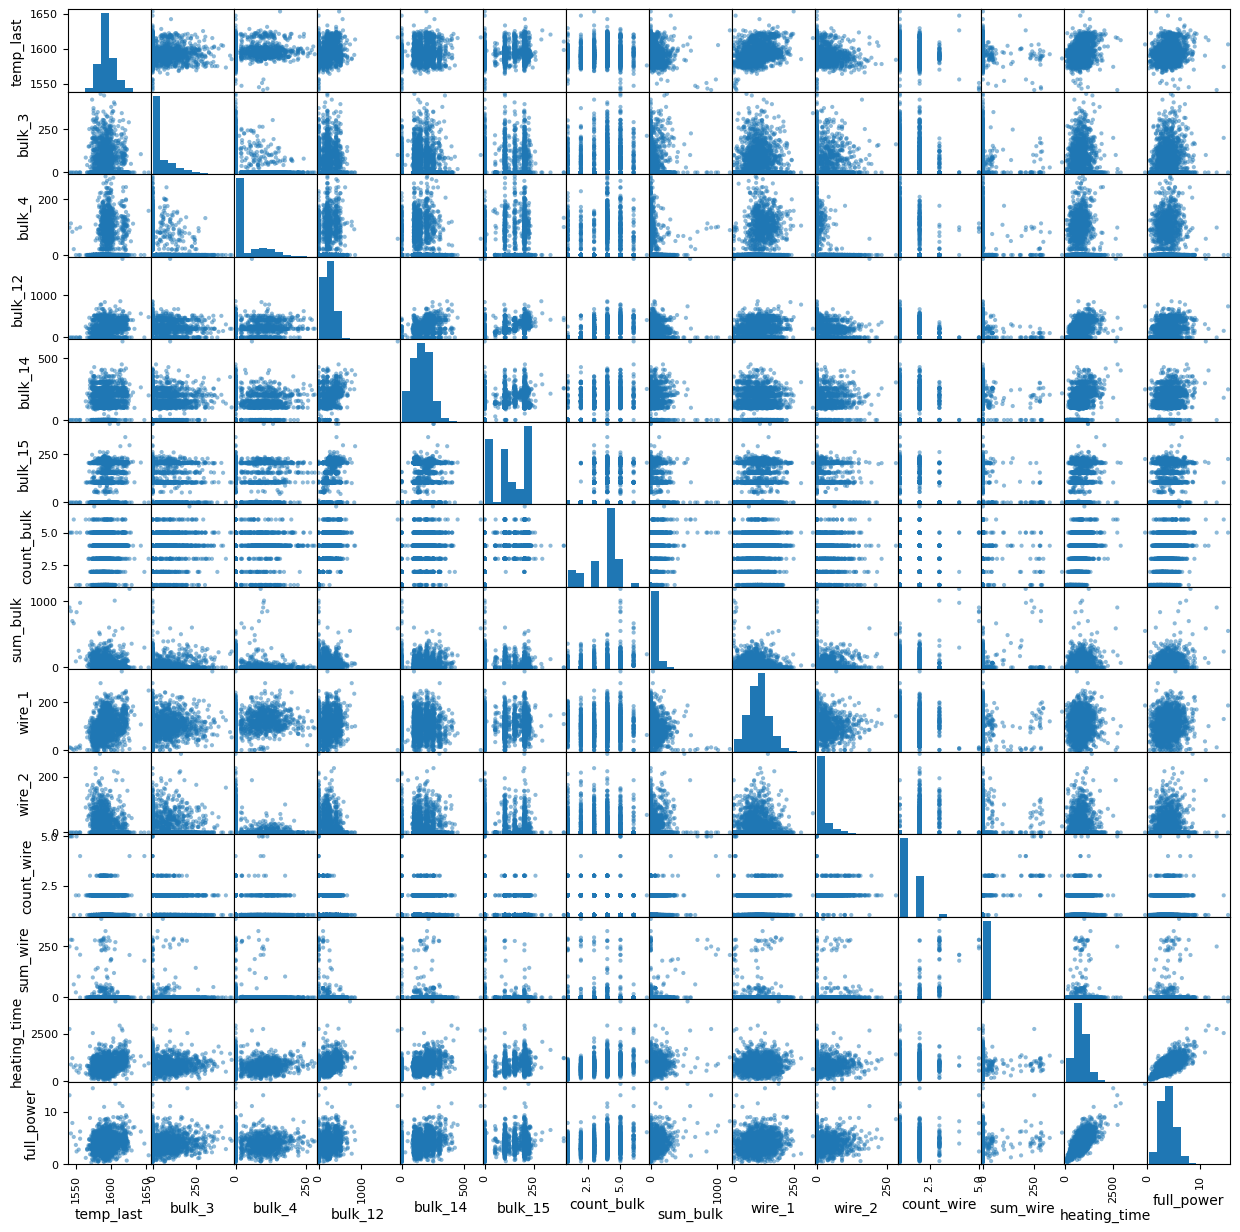

In [64]:
pd.plotting.scatter_matrix(df.iloc [:, 2:16], figsize=(15,15));

> Из heatmap и графиков видно, что есть сильная линельная зависимость между heating_time, full_power и energy, при этом признаки имеют примерно одинаковый уровень корреляции с целевой переменной, поэтому перед обучением удалим из выборки признак heating_time и full_power.

## Обучение модели
Разделим датасет на тренировочную и тестовую в соотношении 75/25, а так же предварительно перемешаем дополнительно наблюдения, так как в изначальном датасете все данные были распределены по времени:

In [65]:
df_shuffled = shuffle(df, random_state=RANDOM_STATE)
df_shuffled.info()

X = df_shuffled.drop(['key', 'temp_last', 'heating_time', 'full_power'], axis=1)
y = df_shuffled['temp_last']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)
cv_counts = 5

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 2138 to 1622
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2293 non-null   int64  
 1   temp_first    2293 non-null   int16  
 2   temp_last     2293 non-null   int16  
 3   bulk_3        2293 non-null   int16  
 4   bulk_4        2293 non-null   float64
 5   bulk_12       2293 non-null   int16  
 6   bulk_14       2293 non-null   int16  
 7   bulk_15       2293 non-null   int16  
 8   count_bulk    2293 non-null   int8   
 9   sum_bulk      2293 non-null   int16  
 10  wire_1        2293 non-null   float64
 11  wire_2        2293 non-null   float64
 12  count_wire    2293 non-null   int8   
 13  sum_wire      2293 non-null   float64
 14  heating_time  2293 non-null   int64  
 15  full_power    2293 non-null   float64
 16  energy        2293 non-null   float64
 17  gas           2293 non-null   float64
dtypes: float64(7), int16(7), 

###  Ridge
Из документации модели: ридж-регрессия - это метод, который можно использовать для подбора модели регрессии, когда в данных присутствует мультиколлинеарность.

У нас есть подготовленные данные df_shuffled, в которых сохранены все признаки.

In [66]:
df_shuffled.head()

,key,temp_first,temp_last,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,count_bulk,sum_bulk,wire_1,wire_2,count_wire,sum_wire,heating_time,full_power,energy,gas
2138,2194,1581,1578,0,0.0,137,124,108,5,161,36.079678,56.127762,2,0.0,173,0.559454,96.785485,6.466818
1321,1359,1584,1598,62,109.0,203,102,104,5,0,113.162399,0.000000,1,0.0,934,5.052502,832.089081,7.130730
2060,2116,1579,1578,0,0.0,0,198,0,2,137,75.216965,0.000000,1,0.0,324,2.457096,270.727227,11.582547
1377,1417,1559,1575,225,0.0,253,151,207,6,151,76.096802,72.112556,2,0.0,834,3.050998,651.419655,8.855217
2185,2241,1586,1583,0,0.0,0,247,0,2,59,93.038399,0.000000,1,0.0,619,3.431970,643.940094,0.992751


In [67]:
features = df_shuffled.drop(['key', 'temp_last'], axis=1)
target = df_shuffled['temp_last']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [68]:
ridge=Ridge()
hyperparams = {'alpha':[10**x for x in range(-4,4)]}

ridge_reg = GridSearchCV(ridge, param_grid=hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
ridge_reg.fit(features_train, target_train)
print("Best parameters set found on development set: ",ridge_reg.best_params_)
print("Best MAE: {:.2f}".format(-ridge_reg.best_score_))

Best parameters set found on development set:  {'alpha': 100}
Best MAE: 6.52


In [69]:
ridge_mod = Ridge(alpha=1000)
ridge_mod.fit(features_train, target_train)
target_pred_train = ridge_mod.predict(features_train)
target_pred_test = ridge_mod.predict(features_test)


print('MAE Ridge на обучающей/тестовой выборке: {:.2f}/{:.2f}' \
      .format(mean_absolute_error(target_train, target_pred_train),
              mean_absolute_error(target_test, target_pred_test)))

MAE Ridge на обучающей/тестовой выборке: 6.44/6.58


### RandomForestRegressor

In [70]:
%%time

rfr_model = RandomForestRegressor()
hyperparams = [{'criterion':['squared_error'],
                'n_estimators':[x for x in range(100, 1001, 50)],
                'random_state':[RANDOM_STATE]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(rfr_model, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts, error_score='raise')
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'squared_error', 'n_estimators': 250, 'random_state': 270223}

Grid scores on development set:

6.657131 for {'criterion': 'squared_error', 'n_estimators': 100, 'random_state': 270223}
6.628522 for {'criterion': 'squared_error', 'n_estimators': 150, 'random_state': 270223}
6.622628 for {'criterion': 'squared_error', 'n_estimators': 200, 'random_state': 270223}
6.605801 for {'criterion': 'squared_error', 'n_estimators': 250, 'random_state': 270223}
6.618089 for {'criterion': 'squared_error', 'n_estimators': 300, 'random_state': 270223}
6.615122 for {'criterion': 'squared_error', 'n_estimators': 350, 'random_state': 270223}
6.607023 for {'criterion': 'squared_error', 'n_estimators': 400, 'random_state': 270223}
6.608215 for {'criterion': 'squared_error', 'n_estimators': 450, 'random_state': 270223}
6.612211 for {'criterion': 'squared_error', 'n_estimators': 500, 'random_state':

### CatBoostRegressor

In [71]:
%%time

cat_model = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(cat_model,
                              X_train,
                              y_train,
                              cv=cv_counts,
                              scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 6.6495267140759395
CPU times: user 27 s, sys: 1.56 s, total: 28.6 s
Wall time: 17.1 s


In [72]:
best_params_CBR = CatBoostRegressor(verbose=False,
                                    random_state=RANDOM_STATE).fit(X_train,
                                                                   y_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 270223,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04460199922323227,
 'score_functio

### LGBMRegressor

In [73]:
%%time

lgbm_model = LGBMRegressor()
hyperparams = [{'num_leaves':[x for x in range(10,31)],
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[RANDOM_STATE]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(lgbm_model, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.03, 'num_leaves': 25, 'random_state': 270223}

Grid scores on development set:

7.179843 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 270223}
7.148816 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 270223}
7.130730 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 270223}
7.112789 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 270223}
7.109898 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 270223}
7.092494 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 270223}
7.083513 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 270223}
7.080139 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 270223}
7.069423 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 270223}
7.058502 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 270223}
7.053374 for

### XGBRegressor

In [74]:
%%time

xgb_model = XGBRegressor()
hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[RANDOM_STATE]}]
# hyperparams = [{'num_leaves':[100],
#                 'learning_rate':[0.16],
#                 'random_state':[RANDOM_STATE]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(xgb_model, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.07, 'random_state': 270223}

Grid scores on development set:

583.466077 for {'learning_rate': 0.01, 'random_state': 270223}
211.557605 for {'learning_rate': 0.02, 'random_state': 270223}
75.962260 for {'learning_rate': 0.03, 'random_state': 270223}
27.233630 for {'learning_rate': 0.04, 'random_state': 270223}
10.697858 for {'learning_rate': 0.05, 'random_state': 270223}
7.050817 for {'learning_rate': 0.06, 'random_state': 270223}
6.579915 for {'learning_rate': 0.07, 'random_state': 270223}
6.650139 for {'learning_rate': 0.08, 'random_state': 270223}
6.676226 for {'learning_rate': 0.09, 'random_state': 270223}
6.667560 for {'learning_rate': 0.1, 'random_state': 270223}
6.698155 for {'learning_rate': 0.11, 'random_state': 270223}
6.677967 for {'learning_rate': 0.12, 'random_state': 270223}
6.713219 for {'learning_rate': 0.13, 'random_state': 270223}
6.706731 for {'learni

### Константная модель
Для того, чтобы оценивать "адекватность" построенных моделей, целесообразно понять, какой уровень качества дает константная модель.

In [75]:
# сравним работу моделей с работой случайной модели:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(X_train, y_train)
predictions_r_dummy = dummy_regr.predict(X_test)
print('MAE dummy:', mean_absolute_error(y_test, predictions_r_dummy))

MAE dummy: 7.769229132081899


### Сравнение моделей

In [76]:
index = ['RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на CV
RandomForestRegressor,6.605801
CatBoostRegressor,6.649527
LGBMRegressor,6.675181
XGBRegressor,6.579915


> Наши модели предсказывают температуру лучше на 1 градус, чем случайная модель.

## Тестирование модели

In [77]:
# Воспользуемся обученной моделью и посмотрим метрики на тестовой выборке:
model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(X_train, y_train)
target_predict = model.predict(X_test)
test_MAE_XGBR = mean_absolute_error(target_predict, y_test)
print('MAE on test of XGBRegressor =', test_MAE_XGBR)

MAE on test of XGBRegressor = 6.3191495


### Рассмотрим важность параметров

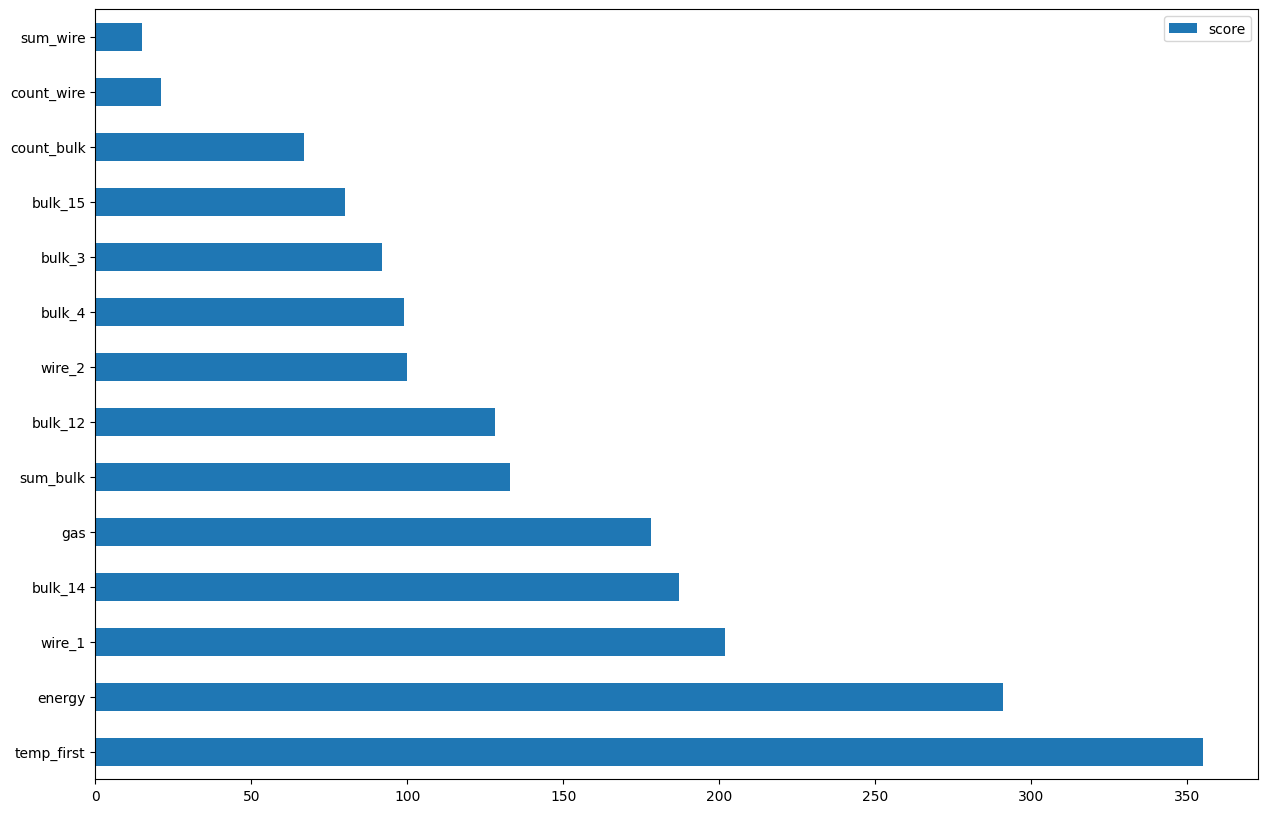

In [78]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(15, columns="score").plot(kind='barh', figsize = (15,10));

### Посчитаем коэффициент детерминации

In [79]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

R^2 train: 0.706, test: 0.370


> Показатель производительности модели на тестовой выборке довольно низкий. Очевидно, данная модель сильно переобучена на тренировочной выборке, и модель плохо работает с неизвестным набором данных.

# Вывод
1. Подготовлены признаки: данные были дополнены новыми параметрами (полной мощностью, полным временем нагрева и энергией). После исследования признаков на мультиколлинеарность пришлось удалить из выборки признаки полная мощность и время нагрева.
2. По таблицам материалов, которые добавлялись в партию, заполнили пустые значения нулями, и рассчитали сумму по редким материалам, а те, которые добавляют часто - оставили без изменений, а так же добавили параметр, в котором посчитали количество добавок в данной партии.
3. Выбросы по всем признакам мы оставили, рассудив, что редкие показатели вызваны особенностями технологического процесса.
4. Для проведения исследования нам нужно было точно знать, что конечное измерение температуры было произведено ПОСЛЕ всех этапов нагрева и подачи всех материлов. Таблицу df_temp с целевой метрикой преобразовали в нужный тип и нашли целевую - последнее измерение температуры, а так же сохранили данные о первом измерении, как дополнительном параметре. У целевой метрики бали пропуски. Очевидно, что такие пропущенные значения заполнить невозможно и эти строки пришлось удалить. Так же удалили те строки, где первое измерение равно последнему, чтобы не допустить утечки данных.
5. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер в серии замеров. Разделены на features и target со смешиванием и масштабированием данных.
6. Для обучения модели были использованы следующий признаки:
 - temp_first - показатели изначальной температуры в ковше до начала всех манипуляций;
 - temp_last - целевая метрика, окончательные показатели тепературы стали;
 - bulk_3 - добавление сыпучих материалов;
 - bulk_4 - добавление сыпучих материалов;
 - bulk_12 - добавление сыпучих материалов;
 - bulk_14 - добавление сыпучих материалов;
 - bulk_15 - добавление сыпучих материалов;
 - count_bulk - количество добавок различных сыпучих материалов на партию;
 - sum_bulk - объем различных сыпучих материалов на партию;
 - wire_1 - добавление проволочных материалов;
 - wire_2 - добавление проволочных материалов;
 - count_wire - количество добавок различных проволочных материалов на партию;
 - sum_wire - объем различных проволочных материалов на партию;
 - energy - дополнительно рассчитанная метрика -энергия: время нагрева умноженное на полную мощность;
 - gas - продувка газом.

7. Из полученных моделей наилучше всего показала себя модель XGBRegressor с параметрами learning_rate: 0.09. Данная модель была использована в тестировании.
8. MAE на тестовой выборке 6.2. Этот результат показывает, что модель в среднем ошибается на 6-7 градусов температуры.